#The Microsoft malware detection project has been divided into 3 notebooks : File and Feature extraction part is done in GCP and training with extracted features is done in colab, due to memory constraints.

(1) 'Byte_feat' notebook contains the extraction of the whole data files and feature extraction of byte files

(2) 'ASM_feat' notebook contains the feature extraction of asm files


(3) 'Modelling' notebook contains all the training of the extracted features.


Mainly, references and code snippets has been taken/inspired from these mentioned sources for the overview and understanding purposes.


(1) https://github.com/dchad/malware-detection

(2) https://github.com/saugatapaul1010/Microsoft-Malware-Detection-using-Machine-Learning/blob/master/Microsoft%20Malware%20Detection%20Latest%20Version.ipynb

(3) https://towardsdatascience.com/malware-classification-using-machine-learning-7c648fb1da79

(4) https://www.youtube.com/watch?v=VLQTRlLGz5Y#t=13m11s

(5) https://www.kaggle.com/c/microsoft-malware-prediction

In [ ]:
#importing some libraries
import array
import imageio,cv2
import os
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
import scipy as sp
from scipy.sparse import vstack

In [ ]:
#assigning the directory
asm_files=os.listdir('asmFiles')

In [ ]:
#creatng a new folder asmFiles_Image
if not os.path.isdir('asmFiles_Image'):
    os.makedirs('asmFiles_Image')

#first attempt to extract features

In [ ]:
#https://towardsdatascience.com/malware-classification-using-machine-learning-7c648fb1da79
#converting each .asm file into into an image

asm_files=os.listdir('asmFiles')
len_asm=len(asm_files) #reading the no. of each .asm file
for i in tqdm(range(len_asm)):
    asm_f=codecs.open('asmFiles/'+asm_files[i],'rb') #reading each byte
    filelen = os.path.getsize("asmFiles/" + asm_files[i]) #each.asm file len
    #print('filelen',filelen)
    width = int(filelen ** 0.5) #width of the square image that will be produced for each .asm file
    #print('width', width)
    rem = int(filelen / width) #similarly the height
    #print('rem',rem)
    a = array.array('B') #assigning an array object
    a.frombytes(asm_f.read()) #reading each byte from the .asm file
    asm_f.close()
    g= np.reshape(a[:width * width], (width, width)) #reshaping the .asm file into images
    #print('reshaped',reshaped)
    g = np.uint8(g) # encoding each file
    imageio.imwrite('asmFiles_Image/'+asm_files[i]+'.png',g) #writing each .png conversion to a new folder

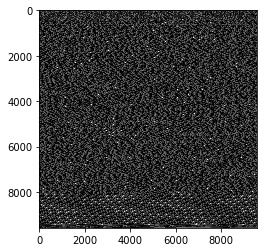

In [ ]:
#https://towardsdatascience.com/malware-classification-using-machine-learning-7c648fb1da79
#to see how does the image of an .asm file looks likes
asm_files=os.listdir('asmFiles')
img=mpimg.imread('asmFiles_Image/'+asm_files[1]+'.png')
imgplot=plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
#to name the top 800 pixels
pix_list=[]
for i in range(800):
    pix_list.append('pixel'+str(i))


In [ ]:
#creating a new empty dataframe
asm_img_df=pd.DataFrame()

In [ ]:
asm_img_df

""


In [ ]:
#assigning the first 800 pixels of each .png to the datframe to use them as features
for i in tqdm(range(len_asm)):
    img = cv2.imread('asmFiles_Image/'+asm_files[i]+'.png')
    img_a = img.flatten()[:800]
    img_a=pd.Series(img_a)
    asm_img_df=asm_img_df.append(img_a,ignore_index=True)


In [ ]:
asm_img_df.shape

(10868, 800)

In [ ]:
#renaming the list
asm_img_df.columns = pix_list

In [ ]:
asm_img_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel790,pixel791,pixel792,pixel793,pixel794,pixel795,pixel796,pixel797,pixel798,pixel799
0,72.0,72.0,72.0,69.0,69.0,69.0,65.0,65.0,65.0,68.0,...,114.0,114.0,105.0,105.0,105.0,103.0,103.0,103.0,104.0,104.0
1,46.0,46.0,46.0,116.0,116.0,116.0,101.0,101.0,101.0,120.0,...,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
2,46.0,46.0,46.0,116.0,116.0,116.0,101.0,101.0,101.0,120.0,...,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
3,72.0,72.0,72.0,69.0,69.0,69.0,65.0,65.0,65.0,68.0,...,114.0,114.0,105.0,105.0,105.0,103.0,103.0,103.0,104.0,104.0
4,46.0,46.0,46.0,116.0,116.0,116.0,101.0,101.0,101.0,120.0,...,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0


In [ ]:
#converting to a .csv file
asm_img_df.to_csv("asm_img_800P")

In [ ]:
len_uni_byte=len(single_uni_byte)

# second attempt to once again extract the features

In [ ]:
#https://github.com/saugatapaul1010/Microsoft-Malware-Detection-using-Machine-Learning/blob/master/Microsoft%20Malware%20Detection%20Latest%20Version.ipynb

file_lists=os.listdir('asmFiles_Image/')

with open("asm_image_df.csv", mode='w') as asm_image_df: #file_lists = 10868, asm_image_df=800
    asm_image_df.write(','.join(map(str, ["ID"]+["Pixel{}".format(i) for i in range(800)])))
    asm_image_df.write('\n')

    for image in tqdm(file_lists):
        file_id=image.split(".")[0]
        image_array=imageio.imread("asmFiles_Image/"+image) #This will contain the image matrix in 2D format
        image_array=image_array.flatten()[:800] #Taking the first 800 pixels from the flattened array
        asm_image_df.write(','.join(map(str, [file_id]+list(image_array))))
        asm_image_df.write('\n') #Write to the dataframe
